# News recommendation system

#### Name: Sivaprasad

### Objective

Recommend relevant news article content to users based on their preferences and interactions with a variety of news articles on the platform and based on what other similar users on the platform consume along with generating algorithms to predict similar news articles.

Two parts:
- Recommend new top 10 relevant articles to a user when he visits the app at the start of the day
- Recommend top 10 similar news articles that match the ones clicked by the user. Try different models for generating these recommendations and experiment with hybrid models for the same


## Data pre-processing

In [78]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks", color_codes=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances 

pd. set_option('display.max_rows', 500)
pd. set_option('display.max_columns', 500)
pd. set_option('display.width', 1000)

In [79]:
consumer_interaction = pd.read_csv("consumer_transanctions.csv")
platform_content = pd.read_csv("platform_content.csv")

D:\Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [80]:
consumer_interaction

,event_timestamp,interaction_type,item_id,consumer_id,consumer_session_id,consumer_device_info,consumer_location,country
0,1465413032,content_watched,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,content_watched,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,content_watched,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,content_followed,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,content_watched,-7820640624231356730,-445337111692715325,561148 1178424124714,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
72307,1485190425,content_liked,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR
72308,1485190425,content_watched,-5813211845057621660,102305705598210278,5527770709392883642,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,SP,BR
72309,1485190072,content_watched,-1999468346928419252,-9196668942822132778,-8300596454915870873,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,SP,BR
72310,1485190434,content_watched,-6590819806697898649,-9016528795238256703,8614469745607949425,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_4...,MG,BR


In [81]:
consumer_interaction.dtypes

event_timestamp          int64
interaction_type        object
item_id                  int64
consumer_id              int64
consumer_session_id     object
consumer_device_info    object
consumer_location       object
country                 object
dtype: object

In [82]:
consumer_interaction.interaction_type.unique()

array(['content_watched', 'content_followed', 'content_saved',
       'content_liked', 'content_commented_on'], dtype=object)

In [83]:
# creating 'ratings' column based on 'interaction_type' column
consumer_interaction['ratings'] = consumer_interaction.interaction_type.map({'content_followed': 5, 'content_commented_on' : 4, 'content saved':3,
                                           'content_liked': 2, 'content_watched': 1})

In [84]:
# taking relevant columns
consumer_interaction = consumer_interaction[['event_timestamp', 'item_id', 'interaction_type', 'consumer_id', 'ratings', 'consumer_location', 'country']]

In [85]:
# exploring platform_content
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [86]:
# Only the articles that are written in the English language must be considered for content-based recommendations
platform_content_en = platform_content[platform_content.language == 'en']

In [87]:
platform_content

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3117,1487946604,content_present,9213260650272029784,3609194402293569455,7144190892417579456,Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebK...,SP,BR,HTML,https://startupi.com.br/2017/02/liga-ventures-...,"Conheça a Liga IoT, plataforma de inovação abe...","A Liga Ventures, aceleradora de startups espec...",pt
3118,1487947067,content_present,-3295913657316686039,6960073744377754728,-8193630595542572738,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3...,GA,US,HTML,https://thenextweb.com/apps/2017/02/14/amazon-...,Amazon takes on Skype and GoToMeeting with its...,"Amazon has launched Chime, a video conferencin...",en
3119,1488223224,content_present,3618271604906293310,1908339160857512799,-183341653743161643,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_0...,SP,BR,HTML,https://code.org/about/2016,Code.org 2016 Annual Report,"February 9, 2017 - We begin each year with a l...",en
3120,1488300719,content_present,6607431762270322325,-1393866732742189886,2367029511384577082,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,MG,BR,HTML,https://www.bloomberg.com/news/articles/2017-0...,JPMorgan Software Does in Seconds What Took La...,"At JPMorgan Chase & Co., a learning machine is...",en


## EDA

In [88]:
consumer_interaction

,event_timestamp,item_id,interaction_type,consumer_id,ratings,consumer_location,country
0,1465413032,-3499919498720038879,content_watched,-8845298781299428018,1.0,NaN,NaN
1,1465412560,8890720798209849691,content_watched,-1032019229384696495,1.0,NY,US
2,1465416190,310515487419366995,content_watched,-1130272294246983140,1.0,NaN,NaN
3,1465413895,310515487419366995,content_followed,344280948527967603,5.0,NaN,NaN
4,1465412290,-7820640624231356730,content_watched,-445337111692715325,1.0,NaN,NaN
...,...,...,...,...,...,...,...
72307,1485190425,-6590819806697898649,content_liked,-9016528795238256703,2.0,MG,BR
72308,1485190425,-5813211845057621660,content_watched,102305705598210278,1.0,SP,BR
72309,1485190072,-1999468346928419252,content_watched,-9196668942822132778,1.0,SP,BR
72310,1485190434,-6590819806697898649,content_watched,-9016528795238256703,1.0,MG,BR


In [89]:
# let's check the distribution
consumer_interaction.describe()

,event_timestamp,item_id,consumer_id,ratings
count,7.231200e+04,7.231200e+04,7.231200e+04,69849.000000
mean,1.470103e+09,-3.033423e+16,1.252026e+16,1.232015
std,7.258130e+06,5.344755e+18,5.022333e+18,0.747193
min,1.457964e+09,-9.222795e+18,-9.223122e+18,1.000000
25%,1.464876e+09,-4.726309e+18,-3.596627e+18,1.000000
50%,1.468343e+09,1.893099e+16,-1.088422e+17,1.000000
75%,1.474461e+09,4.441012e+18,3.766319e+18,1.000000
max,1.488310e+09,9.222265e+18,9.210531e+18,5.000000


In [90]:
# how many unique items?
consumer_interaction.item_id.nunique()

2987

In [91]:
consumer_interaction.interaction_type.value_counts() * 100 / len(consumer_interaction.interaction_type)

content_watched         84.475606
content_liked            7.944739
content_saved            3.406074
content_commented_on     2.227846
content_followed         1.945735
Name: interaction_type, dtype: float64

In [92]:
consumer_interaction.ratings.value_counts() * 100 / len(consumer_interaction.interaction_type)

1.0    84.475606
2.0     7.944739
4.0     2.227846
5.0     1.945735
Name: ratings, dtype: float64

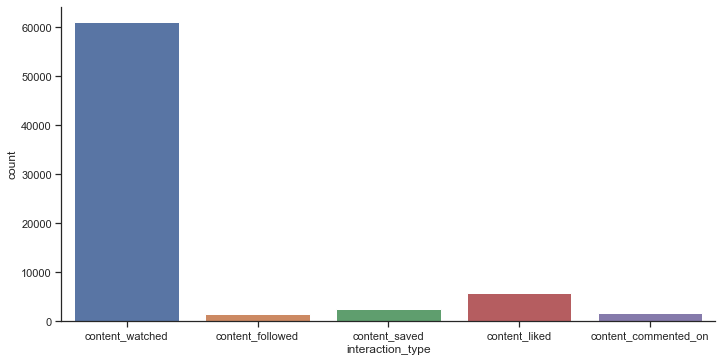

In [93]:
# distribution of interaction type
# Around 85% of the movies are of rating 1 (content_watched)
sns.catplot(x="interaction_type", kind="count", height=5, aspect=2, data=consumer_interaction)

In [94]:
# Let's explore the consumer country and location
print(consumer_interaction.country.nunique())
print(consumer_interaction.country.unique())

23
[nan 'US' 'BR' 'JP' 'KR' 'IN' 'IE' 'SG' 'DE' 'CA' 'IS' 'AU' 'ZZ' 'ES' 'CN'
 'GB' 'MY' 'AR' 'NL' 'CL' 'IT' 'CO' 'PT' 'CH']


BR    51396
US     4657
KR      239
CA      226
JP      144
AU      138
GB       22
DE       19
IE       14
IS       13
SG       11
ZZ       11
AR        7
PT        6
ES        3
IN        3
IT        2
MY        2
CH        1
NL        1
CN        1
CL        1
CO        1
Name: country, dtype: int64


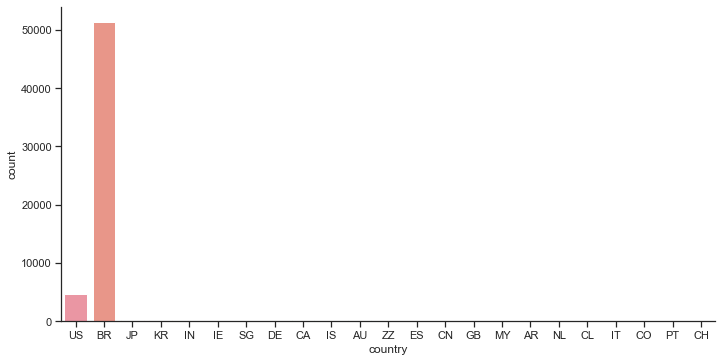

In [95]:
print(consumer_interaction.country.value_counts())
sns.catplot(x="country", kind="count", height=5, aspect=2, data=consumer_interaction)

In [96]:
consumer_interaction.consumer_location.unique()

array([nan, 'NY', 'MG', 'SP', 'RJ', 'GA', 'CA', '?', 'NJ', 'TX', '49',
       'MH', 'D', 'PA', 'VA', 'BE', 'AZ', 'IL', 'MI', 'FL', 'ES', 'BW',
       'MA', 'PR', 'BC', 'NSW', 'DF', 'C', 'HE', 'ON', 'MS', '13', '11',
       'DC', 'NE', 'NC', '33', 'CO', 'LA', 'ENG', 'GO', '14', 'IN', 'CT',
       '45', '27', 'WA', 'PE', 'MO', 'MN', 'RS', 'NH', '41', 'SC', 'BA',
       'WI', 'RM', 'OK', 'OH', 'CE', 'RI', 'AB', 'R', 'BOL', 'NV', 'OR',
       'KS', 'ZH', 'MT', 'QLD', 'PI', 'CL'], dtype=object)

In [97]:
consumer_interaction.consumer_location.value_counts()

SP     40164
MG     10229
NY      1257
TX       923
GA       910
RJ       775
NJ       698
?        327
CA       238
ON       202
NSW      135
IL       113
13       107
PR        88
MI        84
PA        76
FL        49
49        39
MA        39
ES        32
VA        30
CO        29
GO        23
ENG       22
AZ        20
BC        18
45        17
MS        17
KS        17
DF        16
11        16
OH        16
BA        14
BE        12
D         12
DC        11
WA        11
PE        10
CT        10
WI         9
SC         8
C          8
41         7
AB         6
MO         5
LA         5
BW         5
27         4
RS         4
OK         3
RI         3
MH         3
NV         3
QLD        3
NE         3
14         2
IN         2
NC         2
RM         2
HE         2
PI         2
CL         1
33         1
ZH         1
NH         1
CE         1
MT         1
MN         1
BOL        1
R          1
OR         1
Name: consumer_location, dtype: int64

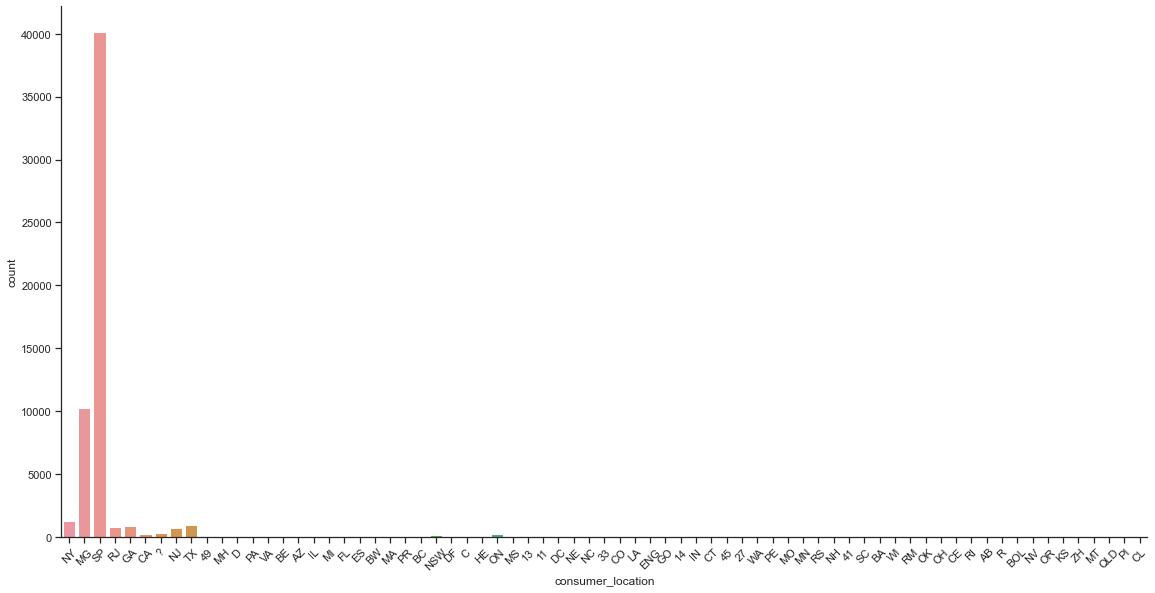

In [98]:
# let's plot the conumer location column
g = sns.catplot(x="consumer_location", kind="count", height=8, aspect=2, data=consumer_interaction)
g.set_xticklabels(rotation=45)



In [99]:
consumer_interaction

,event_timestamp,item_id,interaction_type,consumer_id,ratings,consumer_location,country
0,1465413032,-3499919498720038879,content_watched,-8845298781299428018,1.0,NaN,NaN
1,1465412560,8890720798209849691,content_watched,-1032019229384696495,1.0,NY,US
2,1465416190,310515487419366995,content_watched,-1130272294246983140,1.0,NaN,NaN
3,1465413895,310515487419366995,content_followed,344280948527967603,5.0,NaN,NaN
4,1465412290,-7820640624231356730,content_watched,-445337111692715325,1.0,NaN,NaN
...,...,...,...,...,...,...,...
72307,1485190425,-6590819806697898649,content_liked,-9016528795238256703,2.0,MG,BR
72308,1485190425,-5813211845057621660,content_watched,102305705598210278,1.0,SP,BR
72309,1485190072,-1999468346928419252,content_watched,-9196668942822132778,1.0,SP,BR
72310,1485190434,-6590819806697898649,content_watched,-9016528795238256703,1.0,MG,BR


In [100]:
# Let's check for the duplicate entries.
consumer_interaction[consumer_interaction.duplicated(['item_id', 'consumer_id'])]

,event_timestamp,item_id,interaction_type,consumer_id,ratings,consumer_location,country
8,1465413762,310515487419366995,content_watched,344280948527967603,1.0,NaN,NaN
12,1465415228,3460026829794173084,content_watched,1908339160857512799,1.0,SP,BR
17,1465412288,-7820640624231356730,content_watched,-445337111692715325,1.0,MG,BR
20,1465416196,310515487419366995,content_watched,-1130272294246983140,1.0,SP,BR
22,1465415060,-1492913151930215984,content_watched,4254153380739593270,1.0,NaN,NaN
...,...,...,...,...,...,...,...
72305,1485187998,569574447134368517,content_watched,-5230721907253934520,1.0,SP,BR
72306,1485190133,5484061377044071389,content_watched,3609194402293569455,1.0,SP,BR
72307,1485190425,-6590819806697898649,content_liked,-9016528795238256703,2.0,MG,BR
72308,1485190425,-5813211845057621660,content_watched,102305705598210278,1.0,SP,BR


In [101]:
# let's handle the duplicate entries. 
# Sort using the eventtimestamp column, take the entry with latest timestamp.
consumer_interaction.sort_values(by=['event_timestamp'])

,event_timestamp,item_id,interaction_type,consumer_id,ratings,consumer_location,country
25389,1457963676,8078873160882064481,content_watched,3891637997717104548,1.0,SP,BR
25390,1457964607,8078873160882064481,content_watched,692689608292948411,1.0,SP,BR
8301,1457966363,8078873160882064481,content_watched,-6411371239765052331,1.0,TX,US
4560,1458147079,1179326165172129711,content_watched,-5094446514734487376,1.0,SP,BR
11881,1458148861,1179326165172129711,content_watched,-5299969637554720500,1.0,SP,BR
...,...,...,...,...,...,...,...
69511,1488300723,6607431762270322325,content_watched,-1393866732742189886,1.0,MG,BR
71148,1488307874,4109618890343020064,content_watched,3891637997717104548,1.0,SP,BR
71150,1488308005,4109618890343020064,content_commented_on,3891637997717104548,4.0,SP,BR
71149,1488308005,4109618890343020064,content_followed,3891637997717104548,5.0,SP,BR


In [102]:
# Let's keep only the last entry
print(consumer_interaction[consumer_interaction.duplicated(['item_id', 'consumer_id'], keep='last')])
consumer_interaction.drop_duplicates(subset=['item_id', 'consumer_id'], keep='last', inplace=True)

       event_timestamp              item_id  interaction_type          consumer_id  ratings consumer_location country
0           1465413032 -3499919498720038879   content_watched -8845298781299428018      1.0               NaN     NaN
1           1465412560  8890720798209849691   content_watched -1032019229384696495      1.0                NY      US
2           1465416190   310515487419366995   content_watched -1130272294246983140      1.0               NaN     NaN
3           1465413895   310515487419366995  content_followed   344280948527967603      5.0               NaN     NaN
4           1465412290 -7820640624231356730   content_watched  -445337111692715325      1.0               NaN     NaN
...                ...                  ...               ...                  ...      ...               ...     ...
72277       1485784333 -1415040208471067980   content_watched  4313045637915476309      1.0                SP      BR
72281       1485781090   991271693336573226   content_wa

<ipython-input-102-6df1a7f5989b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  consumer_interaction.drop_duplicates(subset=['item_id', 'consumer_id'], keep='last', inplace=True)


In [103]:
consumer_interaction

,event_timestamp,item_id,interaction_type,consumer_id,ratings,consumer_location,country
12,1465415228,3460026829794173084,content_watched,1908339160857512799,1.0,SP,BR
17,1465412288,-7820640624231356730,content_watched,-445337111692715325,1.0,MG,BR
22,1465415060,-1492913151930215984,content_watched,4254153380739593270,1.0,NaN,NaN
26,1465415695,7763750328910542816,content_watched,1908339160857512799,1.0,NaN,NaN
30,1465413771,3064370296170038610,content_watched,3609194402293569455,1.0,SP,BR
...,...,...,...,...,...,...,...
72306,1485190133,5484061377044071389,content_watched,3609194402293569455,1.0,SP,BR
72308,1485190425,-5813211845057621660,content_watched,102305705598210278,1.0,SP,BR
72309,1485190072,-1999468346928419252,content_watched,-9196668942822132778,1.0,SP,BR
72310,1485190434,-6590819806697898649,content_watched,-9016528795238256703,1.0,MG,BR


In [104]:
# let's look at platform_content

platform_content.describe()


,event_timestamp,item_id,producer_id,producer_session_id
count,3.122000e+03,3.122000e+03,3.122000e+03,3.122000e+03
mean,1.468804e+09,3.284110e+16,3.984819e+17,1.976675e+17
std,7.571512e+06,5.383734e+18,4.387115e+18,5.403753e+18
min,1.459193e+09,-9.222795e+18,-9.120686e+18,-9.212055e+18
25%,1.462369e+09,-4.660869e+18,-1.578288e+18,-4.651280e+18
50%,1.467136e+09,4.436584e+16,-7.092877e+17,4.154103e+17
75%,1.473873e+09,4.745617e+18,3.609194e+18,4.841644e+18
max,1.488308e+09,9.222265e+18,9.210531e+18,9.221043e+18


In [105]:
platform_content.head()

,event_timestamp,interaction_type,item_id,producer_id,producer_session_id,producer_device_info,producer_location,producer_country,item_type,item_url,title,text_description,language
0,1459192779,content_pulled_out,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,content_present,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,content_present,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,content_present,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,content_present,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


In [106]:
platform_content.language.value_counts()

en    2264
pt     850
la       4
ja       2
es       2
Name: language, dtype: int64

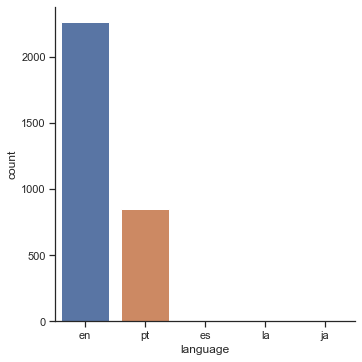

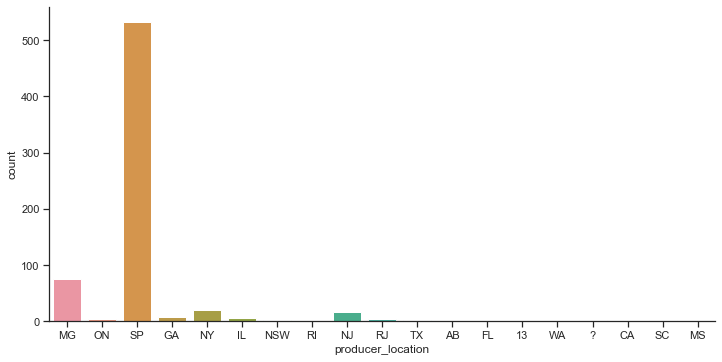

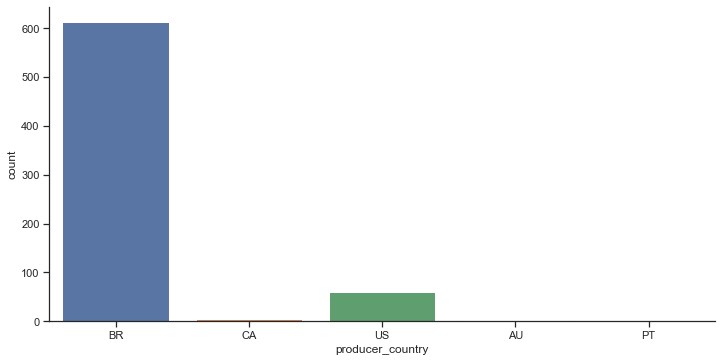

In [107]:
sns.catplot(x="language", kind="count", data=platform_content)
sns.catplot(x="producer_location", kind="count", height=5, aspect=2, data=platform_content)
sns.catplot(x="producer_country", kind="count", height=5, aspect=2, data=platform_content)

In [108]:
platform_content.item_type.nunique()

3

In [109]:
platform_content.item_type.unique()

array(['HTML', 'RICH', 'VIDEO'], dtype=object)

In [110]:
platform_content.item_url.nunique()

3029

In [111]:
# taking relevant columns
platform_content = platform_content[['interaction_type', 'item_id', 'producer_id', 'title',
                                     'producer_location', 'producer_country', 'text_description', 'language']]
platform_content

,interaction_type,item_id,producer_id,title,producer_location,producer_country,text_description,language
0,content_pulled_out,-6451309518266745024,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",NaN,NaN,All of this work is still very early. The firs...,en
1,content_present,-4110354420726924665,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",NaN,NaN,All of this work is still very early. The firs...,en
2,content_present,-7292285110016212249,4340306774493623681,Bitcoin Future: When GBPcoin of Branson Wins O...,NaN,NaN,The alarm clock wakes me at 8:00 with stream o...,en
3,content_present,-6151852268067518688,3891637997717104548,Google Data Center 360° Tour,NaN,NaN,We're excited to share the Google Data Center ...,en
4,content_present,2448026894306402386,4340306774493623681,"IBM Wants to ""Evolve the Internet"" With Blockc...",NaN,NaN,The Aite Group projects the blockchain market ...,en
...,...,...,...,...,...,...,...,...
3117,content_present,9213260650272029784,3609194402293569455,"Conheça a Liga IoT, plataforma de inovação abe...",SP,BR,"A Liga Ventures, aceleradora de startups espec...",pt
3118,content_present,-3295913657316686039,6960073744377754728,Amazon takes on Skype and GoToMeeting with its...,GA,US,"Amazon has launched Chime, a video conferencin...",en
3119,content_present,3618271604906293310,1908339160857512799,Code.org 2016 Annual Report,SP,BR,"February 9, 2017 - We begin each year with a l...",en
3120,content_present,6607431762270322325,-1393866732742189886,JPMorgan Software Does in Seconds What Took La...,MG,BR,"At JPMorgan Chase & Co., a learning machine is...",en


In [112]:
# Total number of unique items in consumer_interactions
print(consumer_interaction.item_id.nunique())

print(platform_content.item_id.nunique())

print(platform_content.item_id.nunique() - consumer_interaction.item_id.nunique())

2987
3057
70


In [113]:
# list the items missing from consumer_interaction
set(platform_content.item_id.unique()) - set(consumer_interaction.item_id.unique())

{-8858741052589364245,
 -8531951303518498324,
 -8473322535064919980,
 -8294676699502353515,
 -8120372343967636100,
 -8112397019636931887,
 -8044741783031984918,
 -7904267039294833672,
 -7863574628164051955,
 -7814257818245609902,
 -7414654466964102039,
 -6275771337261603227,
 -5997023418322622504,
 -5968239566051821631,
 -5802731238371220572,
 -5623496706605874646,
 -4880614998012292765,
 -4291244850221551577,
 -3319960804317299025,
 -2880002165720705376,
 -2649418407515952078,
 -2309481887656981309,
 -2273517184910006534,
 -2148899391355011268,
 -1549326815285717811,
 -847494979958007433,
 -776023644693624658,
 -609005539129550395,
 -504935756748713175,
 -456161980484814803,
 -253149055249888078,
 -74919696966767903,
 5268351851132250,
 245828856632598563,
 476793294516827044,
 614512039577184122,
 756136904399885845,
 984451487666392184,
 1058260959930395162,
 1181375551449952059,
 1190376095547142533,
 1347061627677516149,
 1400543852157442197,
 1790561775815571583,
 202286947328041

In [114]:
set(consumer_interaction.item_id.unique()) - set(platform_content.item_id.unique())

set()

## User based collaborative filtering

In [121]:
print(consumer_interaction.item_id.nunique())
print(consumer_interaction.consumer_id.nunique())

2987
1895


In [162]:
consumer_interaction_train, consumer_interaction_test = train_test_split(consumer_interaction, test_size=0.30, random_state=31)

In [163]:
print(consumer_interaction_train.shape)
print(consumer_interaction_test.shape)

(28497, 7)
(12213, 7)


In [164]:
# Let's create the user X item matrix
data_matrix_train = consumer_interaction_train.pivot(
    index='consumer_id',
    columns='item_id',
    values='ratings'
).fillna(0)


# data_matrix_test = consumer_interaction_test.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# ).fillna(0)

# data_matrix_complete =  consumer_interaction.pivot(
#     index='consumer_id',
#     columns='item_id',
#     values='ratings'
# ).fillna(0)
data_matrix_train.shape

(1794, 2883)

#### Normalising the rating of the movie for each user around 0 mean

In [165]:
# mean = np.nanmean(data_matrix_train, axis=1)
# data_matrix_train_normalized = (data_matrix_train.T-mean).T

In [166]:
data_matrix_train

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9152398073968262186,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,-9041823059579281174,-9041546321432974047,-9039021554659316935,-9033346036688923648,-9033211547111606164,-9028990334396397584,-9020955625521881630,-9019582414165805420,-9019233957195913605,-9007594455502730692,-9002191823887486987,-8996656559398843485,-8992803137960175254,-8992201526199201450,-8984665034930053829,-8980834789053459155,-8971085667828564532,-8968101771604200516,-8964534883296838326,-8962700386317589038,-8954346068661072425,-8950763842769120954,-8949113594875411859,-8948234514303933700,-8947720860550700506,-8942026248671582808,-8939172344092554931,-8937070974333045193,-8934199835393138432,-8933526098329881084,-8913397556833789413,-8909927294729358771,-8908991577172785311,-8900307211613973542,-8900113512825364282,-8885776096632729273,-8879983698341300928,-8876785823151614444,-8864073373672512525,-8863047175241170722,-8854146354650101086,-8819557474068526071,-8815620240581422908,-8813724423497152538,-8801071115335368509,-8800029253812071912,-8797444257711529901,-8796191278504623694,-8781597910014596432,-8773118241761372618,-8771338872124599367,-8763351865833452031,-8762137947059829459,-8757701761088346244,-8742648016180281673,-8734181034726403477,-8728075196312712282,-8723568727518869245,-8723313435347324769,-8722526817358894474,-8717945432162716060,-8706427875719844202,-8704908797766843570,-8700857105739861338,-8689798332822398451,-8689461307495241608,-8686523832043452855,-8681175158863587641,-8680242653057858999,-8677396111092711799,-8669770849634489893,-8658069499367979499,-8657415528200615063,-8651474460024926245,-8641360668993633978,-8632408281960398473,-8627051188605351707,-8618420761918493321,-8615957592921855596,-8615008595949058842,-8606063418076691067,-8591127493017117985,-8587352636561360574,-8582642829303844420,-8578355592291788601,-8535131855706279960,-8529522981244750831,-8526359231369823784,-8520302351158933500,-8518096793350810174,-8512859527034085078,-8512461968928613053,-8511291357261863413,-8510490754427841940,-8508606815368130888,-8508598439431879680,-8502883448980287228,-8497895589300643949,-8489944755890710748,-8480712303720557641,-8467102776052559275,-8460222552900599049,-8449536481786923901,-8427763028519233712,-8426084422061984285,-8418620743404378592,-8412113620940365599,-8404657131309965885,-8392586470872505716,-8391512412740651574,-8381230866408697127,-8377626164558006982,-8370744479086515302,-8369610219380465981,-8368414190009234878,-8353590933060505654,-8349788035147634450,-8340365043226490059,-8314629309720421219,-8312968399134741370,-8311338126170554747,-8287402887944984163,-8286289711960957081,-8282357075607822317,-8279505492976427918,-8278633353687754322,-8278375716950339547,-8277924497842156608,-8259953995965151136,-8258529658421542282,-8257579276626076787,-8254222281357012124,-8248141950199177506,-8245663037926520114,-8244000618837043328,-8243488279185272615,-8239286201029609369,-8222568914848295086,-8208801367848627943,-8204817396973648779,-8202212195240926680,-8196748324041706598,-8194774279664546436,-8193923078932592165,-8190931845319543363,-8189315446782327370,-8187220755213888616,-8167536150098135304,-8159730897893673528,-8158171393641147845,-8

In [167]:
# Let's calculate the pairwise distance

consumer_similarity = 1 - pairwise_distances(data_matrix_train, metric='cosine')
# consumer_similarity[np.isnan(consumer_similarity)] = 0
consumer_similarity

array([[1.        , 0.        , 0.        , ..., 0.02819419, 0.05423261,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.28284271,
        0.        ],
       ...,
       [0.02819419, 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.05423261, 0.        , 0.28284271, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [168]:
# Dot product of consumer_similarity matrix and data_matrix_test to get the predictions

item_prediction = np.dot(consumer_similarity, data_matrix_train)

In [169]:
item_prediction

array([[0.06859943, 0.18636993, 0.26479326, ..., 0.2493742 , 0.44303747,
        0.10438396],
       [0.        , 0.73625521, 0.04391861, ..., 0.        , 0.19611614,
        0.        ],
       [0.        , 2.2725771 , 0.        , ..., 0.05      , 0.24806947,
        0.        ],
       ...,
       [0.02559689, 0.        , 0.40190544, ..., 0.08481249, 0.33772372,
        0.01389425],
       [0.        , 0.33483024, 0.1635471 , ..., 0.1294327 , 0.45485437,
        0.        ],
       [0.0147442 , 0.04755193, 0.46777489, ..., 0.09277062, 0.38792102,
        0.02791724]])

In [170]:
item_prediction.shape

(1794, 2883)

In [171]:
len(list(data_matrix_train.columns))

2883

In [172]:
# Set the columns with item ids
# item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns))
# item_prediction_df.insert(0, 'consumer_id', data_matrix_train.reset_index().consumer_id)
# item_prediction_df.set_index(["consumer_id"],append = True, drop = True, inplace=True)

In [173]:
item_prediction_df = pd.DataFrame(item_prediction, columns=list(data_matrix_train.columns), index=data_matrix_train.index)

In [174]:
item_prediction_df

,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9152398073968262186,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,-9041823059579281174,-9041546321432974047,-9039021554659316935,-9033346036688923648,-9033211547111606164,-9028990334396397584,-9020955625521881630,-9019582414165805420,-9019233957195913605,-9007594455502730692,-9002191823887486987,-8996656559398843485,-8992803137960175254,-8992201526199201450,-8984665034930053829,-8980834789053459155,-8971085667828564532,-8968101771604200516,-8964534883296838326,-8962700386317589038,-8954346068661072425,-8950763842769120954,-8949113594875411859,-8948234514303933700,-8947720860550700506,-8942026248671582808,-8939172344092554931,-8937070974333045193,-8934199835393138432,-8933526098329881084,-8913397556833789413,-8909927294729358771,-8908991577172785311,-8900307211613973542,-8900113512825364282,-8885776096632729273,-8879983698341300928,-8876785823151614444,-8864073373672512525,-8863047175241170722,-8854146354650101086,-8819557474068526071,-8815620240581422908,-8813724423497152538,-8801071115335368509,-8800029253812071912,-8797444257711529901,-8796191278504623694,-8781597910014596432,-8773118241761372618,-8771338872124599367,-8763351865833452031,-8762137947059829459,-8757701761088346244,-8742648016180281673,-8734181034726403477,-8728075196312712282,-8723568727518869245,-8723313435347324769,-8722526817358894474,-8717945432162716060,-8706427875719844202,-8704908797766843570,-8700857105739861338,-8689798332822398451,-8689461307495241608,-8686523832043452855,-8681175158863587641,-8680242653057858999,-8677396111092711799,-8669770849634489893,-8658069499367979499,-8657415528200615063,-8651474460024926245,-8641360668993633978,-8632408281960398473,-8627051188605351707,-8618420761918493321,-8615957592921855596,-8615008595949058842,-8606063418076691067,-8591127493017117985,-8587352636561360574,-8582642829303844420,-8578355592291788601,-8535131855706279960,-8529522981244750831,-8526359231369823784,-8520302351158933500,-8518096793350810174,-8512859527034085078,-8512461968928613053,-8511291357261863413,-8510490754427841940,-8508606815368130888,-8508598439431879680,-8502883448980287228,-8497895589300643949,-8489944755890710748,-8480712303720557641,-8467102776052559275,-8460222552900599049,-8449536481786923901,-8427763028519233712,-8426084422061984285,-8418620743404378592,-8412113620940365599,-8404657131309965885,-8392586470872505716,-8391512412740651574,-8381230866408697127,-8377626164558006982,-8370744479086515302,-8369610219380465981,-8368414190009234878,-8353590933060505654,-8349788035147634450,-8340365043226490059,-8314629309720421219,-8312968399134741370,-8311338126170554747,-8287402887944984163,-8286289711960957081,-8282357075607822317,-8279505492976427918,-8278633353687754322,-8278375716950339547,-8277924497842156608,-8259953995965151136,-8258529658421542282,-8257579276626076787,-8254222281357012124,-8248141950199177506,-8245663037926520114,-8244000618837043328,-8243488279185272615,-8239286201029609369,-8222568914848295086,-8208801367848627943,-8204817396973648779,-8202212195240926680,-8196748324041706598,-8194774279664546436,-8193923078932592165,-8190931845319543363,-8189315446782327370,-8187220755213888616,-8167536150098135304,-8159730897893673528,-8158171393641147845,-81494291

In [175]:
item_prediction_df.loc[-9223121837663643404]

-9222795471790223670    0.068599
-9216926795620865886    0.186370
-9194572880052200111    0.264793
-9192549002213406534    1.455150
-9190737901804729417    0.084063
                          ...   
 9213260650272029784    0.155193
 9215261273565326920    0.418723
 9217155070834564627    0.249374
 9220445660318725468    0.443037
 9222265156747237864    0.104384
Name: -9223121837663643404, Length: 2883, dtype: float64

In [181]:
# Create a dummy train pivot table for recommending unseen items.
# Dummy train will be used later for prediction of the items which has not been rated by the user. 
# To ignore the items rated by the user, we will mark it as 0 during prediction. 
# The items not rated by user is marked as 1 for prediction in dummy train dataset.

dummy_train = data_matrix_train.copy()

In [182]:
for c in dummy_train.columns:
    dummy_train[c] = dummy_train[c].apply(lambda x: 1.0 if x == 0.0 else 0.0)

In [183]:
dummy_train

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9152398073968262186,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,-9041823059579281174,-9041546321432974047,-9039021554659316935,-9033346036688923648,-9033211547111606164,-9028990334396397584,-9020955625521881630,-9019582414165805420,-9019233957195913605,-9007594455502730692,-9002191823887486987,-8996656559398843485,-8992803137960175254,-8992201526199201450,-8984665034930053829,-8980834789053459155,-8971085667828564532,-8968101771604200516,-8964534883296838326,-8962700386317589038,-8954346068661072425,-8950763842769120954,-8949113594875411859,-8948234514303933700,-8947720860550700506,-8942026248671582808,-8939172344092554931,-8937070974333045193,-8934199835393138432,-8933526098329881084,-8913397556833789413,-8909927294729358771,-8908991577172785311,-8900307211613973542,-8900113512825364282,-8885776096632729273,-8879983698341300928,-8876785823151614444,-8864073373672512525,-8863047175241170722,-8854146354650101086,-8819557474068526071,-8815620240581422908,-8813724423497152538,-8801071115335368509,-8800029253812071912,-8797444257711529901,-8796191278504623694,-8781597910014596432,-8773118241761372618,-8771338872124599367,-8763351865833452031,-8762137947059829459,-8757701761088346244,-8742648016180281673,-8734181034726403477,-8728075196312712282,-8723568727518869245,-8723313435347324769,-8722526817358894474,-8717945432162716060,-8706427875719844202,-8704908797766843570,-8700857105739861338,-8689798332822398451,-8689461307495241608,-8686523832043452855,-8681175158863587641,-8680242653057858999,-8677396111092711799,-8669770849634489893,-8658069499367979499,-8657415528200615063,-8651474460024926245,-8641360668993633978,-8632408281960398473,-8627051188605351707,-8618420761918493321,-8615957592921855596,-8615008595949058842,-8606063418076691067,-8591127493017117985,-8587352636561360574,-8582642829303844420,-8578355592291788601,-8535131855706279960,-8529522981244750831,-8526359231369823784,-8520302351158933500,-8518096793350810174,-8512859527034085078,-8512461968928613053,-8511291357261863413,-8510490754427841940,-8508606815368130888,-8508598439431879680,-8502883448980287228,-8497895589300643949,-8489944755890710748,-8480712303720557641,-8467102776052559275,-8460222552900599049,-8449536481786923901,-8427763028519233712,-8426084422061984285,-8418620743404378592,-8412113620940365599,-8404657131309965885,-8392586470872505716,-8391512412740651574,-8381230866408697127,-8377626164558006982,-8370744479086515302,-8369610219380465981,-8368414190009234878,-8353590933060505654,-8349788035147634450,-8340365043226490059,-8314629309720421219,-8312968399134741370,-8311338126170554747,-8287402887944984163,-8286289711960957081,-8282357075607822317,-8279505492976427918,-8278633353687754322,-8278375716950339547,-8277924497842156608,-8259953995965151136,-8258529658421542282,-8257579276626076787,-8254222281357012124,-8248141950199177506,-8245663037926520114,-8244000618837043328,-8243488279185272615,-8239286201029609369,-8222568914848295086,-8208801367848627943,-8204817396973648779,-8202212195240926680,-8196748324041706598,-8194774279664546436,-8193923078932592165,-8190931845319543363,-8189315446782327370,-8187220755213888616,-8167536150098135304,-8159730897893673528,-8158171393641147845,-8

In [186]:
item_pred_unseen = np.multiply(item_prediction,dummy_train)

In [190]:
item_pred_unseen

item_id,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9176143510534135851,-9171475473795142532,-9166778629773133902,-9161596996229760398,-9160910454530522563,-9157338616628196758,-9153494109165200346,-9152398073968262186,-9147114693160126293,-9137036168156595470,-9128741757954228992,-9128652074338368262,-9107331682787867601,-9105040345021932755,-9103776596534246502,-9102431381393428051,-9100490342054218852,-9099155556042679205,-9095002324981651252,-9092333155845304874,-9090514312860140897,-9089854794058353436,-9086955082453789880,-9083294960368598209,-9081753261356157170,-9080873096647717414,-9076501258717815738,-9073210245497295284,-9071883412530082330,-9064100704535292718,-9056114023474725450,-9055044275358686874,-9050450867630628092,-9045753673721269477,-9041823059579281174,-9041546321432974047,-9039021554659316935,-9033346036688923648,-9033211547111606164,-9028990334396397584,-9020955625521881630,-9019582414165805420,-9019233957195913605,-9007594455502730692,-9002191823887486987,-8996656559398843485,-8992803137960175254,-8992201526199201450,-8984665034930053829,-8980834789053459155,-8971085667828564532,-8968101771604200516,-8964534883296838326,-8962700386317589038,-8954346068661072425,-8950763842769120954,-8949113594875411859,-8948234514303933700,-8947720860550700506,-8942026248671582808,-8939172344092554931,-8937070974333045193,-8934199835393138432,-8933526098329881084,-8913397556833789413,-8909927294729358771,-8908991577172785311,-8900307211613973542,-8900113512825364282,-8885776096632729273,-8879983698341300928,-8876785823151614444,-8864073373672512525,-8863047175241170722,-8854146354650101086,-8819557474068526071,-8815620240581422908,-8813724423497152538,-8801071115335368509,-8800029253812071912,-8797444257711529901,-8796191278504623694,-8781597910014596432,-8773118241761372618,-8771338872124599367,-8763351865833452031,-8762137947059829459,-8757701761088346244,-8742648016180281673,-8734181034726403477,-8728075196312712282,-8723568727518869245,-8723313435347324769,-8722526817358894474,-8717945432162716060,-8706427875719844202,-8704908797766843570,-8700857105739861338,-8689798332822398451,-8689461307495241608,-8686523832043452855,-8681175158863587641,-8680242653057858999,-8677396111092711799,-8669770849634489893,-8658069499367979499,-8657415528200615063,-8651474460024926245,-8641360668993633978,-8632408281960398473,-8627051188605351707,-8618420761918493321,-8615957592921855596,-8615008595949058842,-8606063418076691067,-8591127493017117985,-8587352636561360574,-8582642829303844420,-8578355592291788601,-8535131855706279960,-8529522981244750831,-8526359231369823784,-8520302351158933500,-8518096793350810174,-8512859527034085078,-8512461968928613053,-8511291357261863413,-8510490754427841940,-8508606815368130888,-8508598439431879680,-8502883448980287228,-8497895589300643949,-8489944755890710748,-8480712303720557641,-8467102776052559275,-8460222552900599049,-8449536481786923901,-8427763028519233712,-8426084422061984285,-8418620743404378592,-8412113620940365599,-8404657131309965885,-8392586470872505716,-8391512412740651574,-8381230866408697127,-8377626164558006982,-8370744479086515302,-8369610219380465981,-8368414190009234878,-8353590933060505654,-8349788035147634450,-8340365043226490059,-8314629309720421219,-8312968399134741370,-8311338126170554747,-8287402887944984163,-8286289711960957081,-8282357075607822317,-8279505492976427918,-8278633353687754322,-8278375716950339547,-8277924497842156608,-8259953995965151136,-8258529658421542282,-8257579276626076787,-8254222281357012124,-8248141950199177506,-8245663037926520114,-8244000618837043328,-8243488279185272615,-8239286201029609369,-8222568914848295086,-8208801367848627943,-8204817396973648779,-8202212195240926680,-8196748324041706598,-8194774279664546436,-8193923078932592165,-8190931845319543363,-8189315446782327370,-8187220755213888616,-8167536150098135304,-8159730897893673528,-8158171393641147845,-8

In [188]:
platform_content

,interaction_type,item_id,producer_id,title,producer_location,producer_country,text_description,language
0,content_pulled_out,-6451309518266745024,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",NaN,NaN,All of this work is still very early. The firs...,en
1,content_present,-4110354420726924665,4340306774493623681,"Ethereum, a Virtual Currency, Enables Transact...",NaN,NaN,All of this work is still very early. The firs...,en
2,content_present,-7292285110016212249,4340306774493623681,Bitcoin Future: When GBPcoin of Branson Wins O...,NaN,NaN,The alarm clock wakes me at 8:00 with stream o...,en
3,content_present,-6151852268067518688,3891637997717104548,Google Data Center 360° Tour,NaN,NaN,We're excited to share the Google Data Center ...,en
4,content_present,2448026894306402386,4340306774493623681,"IBM Wants to ""Evolve the Internet"" With Blockc...",NaN,NaN,The Aite Group projects the blockchain market ...,en
...,...,...,...,...,...,...,...,...
3117,content_present,9213260650272029784,3609194402293569455,"Conheça a Liga IoT, plataforma de inovação abe...",SP,BR,"A Liga Ventures, aceleradora de startups espec...",pt
3118,content_present,-3295913657316686039,6960073744377754728,Amazon takes on Skype and GoToMeeting with its...,GA,US,"Amazon has launched Chime, a video conferencin...",en
3119,content_present,3618271604906293310,1908339160857512799,Code.org 2016 Annual Report,SP,BR,"February 9, 2017 - We begin each year with a l...",en
3120,content_present,6607431762270322325,-1393866732742189886,JPMorgan Software Does in Seconds What Took La...,MG,BR,"At JPMorgan Chase & Co., a learning machine is...",en


In [193]:
# Recommended items for the user -9212075797126931087

d = item_pred_unseen.loc[-9212075797126931087].sort_values(ascending=False)[0:10]

In [194]:
pd.merge(d,platform_content,left_on='item_id',right_on='item_id', how = 'left')

,item_id,-9212075797126931087,interaction_type,producer_id,title,producer_location,producer_country,text_description,language
0,7521700660190108859,1.161268,content_present,-7118575739764684077,Como são escrita as risadas em japonês? - Suki...,NaN,NaN,Todos conhecem as universais formas de risadas...,pt
1,7507067965574797372,1.116234,content_present,-4028919343899978105,Um bilhão de arquivos mostram quem vence a dis...,NaN,NaN,Esta é uma das maiores batalhas já travadas en...,pt
2,-5527182266336855540,1.003047,content_present,2833428826475063405,40 Basic Japanese conversations,NaN,NaN,Japanese conversation using Ninja LINE sticker...,ja
3,-3790313320969344469,0.988589,content_present,2833428826475063405,The Great Library,NaN,NaN,"hen learning Japanese, reading often makes up ...",en
4,-6843047699859121724,0.922956,content_present,7527226129639571966,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",NaN,NaN,"Ganhe 6 meses de acesso ao Pluralsight, maior ...",pt
5,-4434534460030275781,0.870512,content_present,2833428826475063405,"The Algorithm March, Japan's Strangely Enterta...",NaN,NaN,Arugorizumu Koushin! アルゴリズムこうしん (Algorithm Mar...,ja
6,2581138407738454418,0.807423,content_present,6756039155228175109,10 Modern Software Over-Engineering Mistakes,NaN,NaN,10 Modern Software Over-Engineering Mistakes F...,en
7,-9216926795620865886,0.736255,content_present,-7711052404720939396,Request lesson : How and when to use はず(=hazu)...,NaN,NaN,= Kotoshi no aki made niwa kare ga dekiru hazu...,la
8,-5784991738549272379,0.684726,content_present,2279740393166882579,NodeMCU (ESP8266) o módulo que desbanca o Ardu...,NaN,NaN,A partir de 2005 o Arduino se tornou a princip...,pt
9,-6783772548752091658,0.644319,content_present,4918484843075254252,Livro: Retrospectivas Divertidas,NaN,NaN,"Neste livro, nós fornecemos um conjunto de fer...",pt


### Evaluation